In [57]:
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.fft import fft

from sklearn.metrics import f1_score
from xgboost import plot_importance, plot_tree

import numpy as np
import pandas as pd
import itertools

#CREARE VALIDATION SET PER SELEZIONE FEATURES?


perimeter = ['BAL']#, 'YSL', 'GIV', 'ALL']
target = 'month_variation'
#initial_features_comb = ['qty_rol_mean', 'qty_rol_std', 'Google_imm_rol_mean', 'Google_imm_rol_std', 'lvmh_stock_price_rol_mean', 'lvmh_stock_price_rol_std', 'kering_stock_price_rol_mean', 'kering_stock_price_rol_std', 'qty-0', 'qty_V_0', 'qty-1', 'qty_V_1', 'qty-2', 'qty_V_2', 'qty_V_3', 'qty_V_4', 'qty_V_5']
cat_cols = ['month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','week_of_month_1','week_of_month_2','week_of_month_3','week_of_month_4','week_of_month_5']
#initial_features_comb = initial_features_comb + cat_cols

scores_df = pd.DataFrame(columns = ['brand', 'score', 'features', 'params']) 

cv_splits = 3
tscv = TimeSeriesSplit(n_splits = cv_splits)  


def add_row_to_df(df, dict_row):
    return pd.concat([df, pd.DataFrame(dict_row)], ignore_index=True)


df = pd.read_csv(f'features_extraction/BAL.csv', index_col='date')

features_comb = df.columns

print(f"Features combination: {' '.join(features_comb)}")

df = df[df.index <= '2023-02-31'] ###########################--------------------------------overfitting extra test


Features combination: qty_rol_mean qty_rol_std qty_rol_max qty_rol_min Google_imm_rol_mean Google_imm_rol_std Google_imm_rol_max Google_imm_rol_min lvmh_stock_price_rol_mean lvmh_stock_price_rol_std lvmh_stock_price_rol_max lvmh_stock_price_rol_min kering_stock_price_rol_mean kering_stock_price_rol_std kering_stock_price_rol_max kering_stock_price_rol_min ftse_mib_price_rol_mean ftse_mib_price_rol_std ftse_mib_price_rol_max ftse_mib_price_rol_min qty-0 qty_V_0 qty-1 qty_V_1 qty-2 qty_V_2 qty-3 qty_V_3 qty-4 qty_V_4 qty-5 qty_V_5 qty-6 qty_V_6 qty-7 qty_V_7 Google_imm-0 Google_imm_V_0 Google_imm-1 Google_imm_V_1 Google_imm-2 Google_imm_V_2 Google_imm-3 Google_imm_V_3 Google_imm-4 Google_imm_V_4 Google_imm-5 Google_imm_V_5 Google_imm-6 Google_imm_V_6 Google_imm-7 Google_imm_V_7 lvmh_stock_price-0 lvmh_stock_price_V_0 lvmh_stock_price-1 lvmh_stock_price_V_1 lvmh_stock_price-2 lvmh_stock_price_V_2 lvmh_stock_price-3 lvmh_stock_price_V_3 lvmh_stock_price-4 lvmh_stock_price_V_4 lvmh_stock_pr

In [61]:
a = list(df.columns).remove(target)

In [62]:
preint(a)

NameError: name 'preint' is not defined

In [ ]:

for col in cat_cols:
    df[col] = df[col].astype("category")

df = df[[target] + [c for c in features_comb if c in df.columns]]

X_cat_cols = [col for col in df.columns if col in cat_cols]
X_scalar_cols = [col for col in df.columns if col != target and col not in X_cat_cols]

X_cols = [col for col in df.columns if col != target]
X = df[X_cols]
y = df[[target]]

best_score = 0
#divider = 0
#weight = 0
best_params = None
best_features_by_importance = []



f1_values = []

xgb = XGBClassifier( verbosity = 0, scoring = 'f1', enable_categorical = True)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #scaling


In [56]:
df[[target]]

,month_variation,month_variation
date,,
2019-07-21,1,1
2019-07-28,0,0
2019-08-04,0,0
2019-08-11,1,1
2019-08-18,0,0
...,...,...
2023-01-29,0,0
2023-02-05,0,0
2023-02-12,0,0


In [ ]:

    X_scaler = MinMaxScaler()
    scaled_data = X_scaler.fit_transform(X_train[X_scalar_cols])
    X_train_scaled = pd.DataFrame(scaled_data, columns=X_scalar_cols, index=X_train.index)
    if len(X_cat_cols) > 0:
        X_train_scaled = pd.concat([X_train_scaled, X_train[X_cat_cols]], axis=1)            

    scaled_data = X_scaler.transform(X_test[X_scalar_cols])
    X_test_scaled = pd.DataFrame(scaled_data, columns=X_scalar_cols, index=X_test.index)
    if len(X_cat_cols) > 0:
        X_test_scaled = pd.concat([X_test_scaled, X_test[X_cat_cols]], axis=1)

    #fitting and pred

    xgb.fit(X_train_scaled, y_train)
    


In [52]:
y_train

,month_variation,month_variation
date,,
2019-07-21,1,1
2019-07-28,0,0
2019-08-04,0,0
2019-08-11,1,1
2019-08-18,0,0
...,...,...
2022-03-06,0,0
2022-03-13,0,0
2022-03-20,0,0


In [ ]:
    y_pred = pd.DataFrame(xgb.predict(X_test_scaled), columns = [target])

    #Evaluation

    f1 = f1_score(y_test, y_pred, average = 'binary', pos_label=1)
    #weight = weight + 1.05**weight
    #divider = divider + weight
    f1_values.append(f1) #*weight

final_score = final_score = np.mean(f1_values)#sum(f1_values)/divider







In [ ]:
import pandas as pd
import numpy as np

In [79]:
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from itertools import combinations

In [80]:
def generate_combinations(original_list):
    result = []
    for r in range(1, len(original_list) + 1):
        result.extend(combinations(original_list, r))
    return [list(combo) for combo in result]

In [81]:
df = pd.read_csv('GIV.csv', index_col = 'date')
df = df[['qty', 'price', 'Google_imm', 'lvmh_stock_price', 'kering_stock_price']]

In [82]:
# cols = list(df.columns)
# comb_cols = [cols[cols.index('qty')]]
# cols.remove('qty')

In [83]:
#generate_combinations(cols)        

In [84]:
print(list(df.columns))

['qty', 'price', 'Google_imm', 'leather_price', 'lvmh_stock_price', 'kering_stock_price']


In [85]:
df = df[['qty', 'price', 'Google_imm', 'lvmh_stock_price', 'kering_stock_price']] #'kering_stock_price'

In [86]:
future = 0
lag = 3
for col in df.columns:
    for i in range(future,lag):
        i = i + 1
        col_name = col+'-'+str(i)
        df[col+'-'+str(i)] = df[col].shift(i)
        df[col+'_V_'+str(i)] = (df[col] - df[col].shift(i)) / df[col].shift(i)
    if col != 'qty':
        df.drop(col, axis = 1, inplace = True)

In [87]:
df.index = pd.to_datetime(df.index)
df['date'] = df.index
df['month'] = df['date'].dt.month
df['month'].astype("category")
df['day'] = df['date'].dt.day
df['day'].astype("category")
df.set_index('date', drop = True, inplace = True)

In [88]:
#df.drop(df.columns[1:6], axis = 1, inplace = True)

In [89]:
df.dropna(inplace = True)

In [90]:
X = df[[col for col in df.columns if col != 'qty']] #df[cols_lag8]
y = df[['qty']]



In [91]:
xgb_model = XGBRegressor(verbosity = 0)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb = GridSearchCV(xgb_model, parameters, cv = 2, n_jobs = 5, verbose=True)


tscv = TimeSeriesSplit(n_splits=3)  

r2_values = []
rmse_values = []


for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb.fit(X_train, y_train)
    
    y_pred = pd.DataFrame(xgb.predict(X_test), columns = ['qty'])

    y_pred = target_scaler.inverse_transform(y_pred)
    y_test = target_scaler.inverse_transform(y_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2_values.append(r2)
    rmse_values.append(rmse)
    print("R2:", r2)
    print("RMSE:", rmse)

    # plt.figure(figsize=(25, 12))
    # plt.plot(y_test.index, y_test, label='Actual')
    # plt.plot(y_test.index, y_pred, label='Predicted')
    # plt.xlabel('Time')
    # plt.ylabel('GIV')
    # plt.title('Actual vs Predicted GIV')
    # plt.legend()
    # plt.show()

# Average MSE across all folds
avg_r2 = np.mean(r2_values)
avg_rmse = np.mean(rmse_values)
print("Average RMSE:", avg_rmse)
print("Average R2:", avg_r2)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
R2: 0.37974062519911556
RMSE: 240.18452343215094
Fitting 2 folds for each of 9 candidates, totalling 18 fits
R2: 0.4190072893784186
RMSE: 155.81337899517348
Fitting 2 folds for each of 9 candidates, totalling 18 fits
R2: 0.6639451374878607
RMSE: 153.7679139815929
Average RMSE: 183.25527213630576
Average R2: 0.487564350688465


In [92]:
df[['qty']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
qty,147.0,927.927498,301.176135,323.330545,736.690812,939.953915,1102.819451,1818.179561


In [93]:
print("MODEL RMSE/M:", avg_rmse/df[['qty']].mean())

MODEL RMSE/M: qty    0.197489
dtype: float64


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

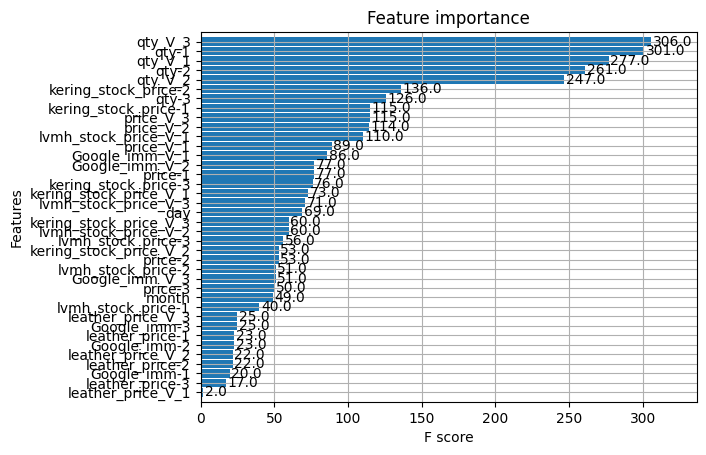

In [94]:
plot_importance(xgb.best_estimator_, height=0.9)

In [28]:


pd.read_csv('http://sdmx.istat.it/SDMXWS/rest/data/IT1,115_168,1.2?startPeriod=2022&endPeriod=2024&format=csv')


HTTPError: HTTP Error 404: Not Found

In [16]:
print(response.content)

b'DATAFLOW,FREQ,ATECO_2007,ADJUSTMENT,ITTER107,IND,TIME_PERIOD,OBS_VALUE,BREAK,CONF_STATUS,OBS_PRE_BREAK,OBS_STATUS,BASE_PER,UNIT_MEAS,UNIT_MULT,METADATA_EN,METADATA_IT\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-01,93.7,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-10,107.7,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-11,108.5,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-12,91.3,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-02,107.4,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-03,122,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-04,103.6,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-05,115.6,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-06,108.6,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-07,110.6,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-08,73.2,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-09,112,,,,,,,,,\r\nIT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2023-01,98.1,,,,

In [33]:
import pandas as pd

url = "http://sdmx.istat.it/SDMXWS/rest/data/IT1,115_333,1.2?startPeriod=2022&endPeriod=2025&format=csv"
df = pd.read_csv(url)
df


,DATAFLOW,FREQ,ATECO_2007,ADJUSTMENT,ITTER107,IND,TIME_PERIOD,OBS_VALUE,BREAK,CONF_STATUS,OBS_PRE_BREAK,OBS_STATUS,BASE_PER,UNIT_MEAS,UNIT_MULT,METADATA_EN,METADATA_IT
0,IT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-01,93.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-10,107.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-11,108.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-12,91.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IT1:115_333(1.2),M,0020,N,IT,IND_PROD2,2022-02,107.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20155,IT1:115_333(1.2),M,D,Y,IT,IND_PROD2,2023-05,94.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20156,IT1:115_333(1.2),M,D,Y,IT,IND_PROD2,2023-06,94.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20157,IT1:115_333(1.2),M,D,Y,IT,IND_PROD2,2023-07,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20158,IT1:115_333(1.2),M,D,Y,IT,IND_PROD2,2023-08,95.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df = pd.read_csv(f'features_extraction/BAL.csv', index_col='date')

In [42]:
for c in df.columns:
    print(c)

qty_rol_mean
qty_rol_std
qty_rol_max
qty_rol_min
Google_imm_rol_mean
Google_imm_rol_std
Google_imm_rol_max
Google_imm_rol_min
lvmh_stock_price_rol_mean
lvmh_stock_price_rol_std
lvmh_stock_price_rol_max
lvmh_stock_price_rol_min
kering_stock_price_rol_mean
kering_stock_price_rol_std
kering_stock_price_rol_max
kering_stock_price_rol_min
ftse_mib_price_rol_mean
ftse_mib_price_rol_std
ftse_mib_price_rol_max
ftse_mib_price_rol_min
qty-0
qty_V_0
qty-1
qty_V_1
qty-2
qty_V_2
qty-3
qty_V_3
qty-4
qty_V_4
qty-5
qty_V_5
qty-6
qty_V_6
qty-7
qty_V_7
Google_imm-0
Google_imm_V_0
Google_imm-1
Google_imm_V_1
Google_imm-2
Google_imm_V_2
Google_imm-3
Google_imm_V_3
Google_imm-4
Google_imm_V_4
Google_imm-5
Google_imm_V_5
Google_imm-6
Google_imm_V_6
Google_imm-7
Google_imm_V_7
lvmh_stock_price-0
lvmh_stock_price_V_0
lvmh_stock_price-1
lvmh_stock_price_V_1
lvmh_stock_price-2
lvmh_stock_price_V_2
lvmh_stock_price-3
lvmh_stock_price_V_3
lvmh_stock_price-4
lvmh_stock_price_V_4
lvmh_stock_price-5
lvmh_stock_price